This tutorial illustrates some basic features of the `stochpy` package with simple 1D diffusion processes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stochpy.dynamics.diffusion1d import Wiener1D, DiffusionProcess1D

# Monte-Carlo simulation of 1D diffusions

## Sample paths

In [2]:
np.random.seed(seed=100)

Let us start by plotting sample paths of the Brownian motion with a one-liner:

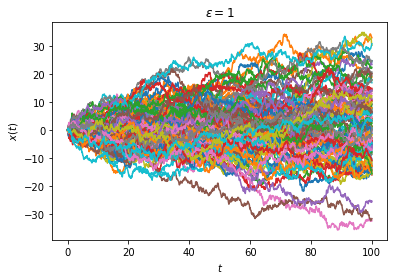

In [3]:
Wiener1D().trajectoryplot(*[Wiener1D().trajectory(0.,0.,T=100) for n in range(100)], title=r'$\epsilon=1$');

Or, in a different style:

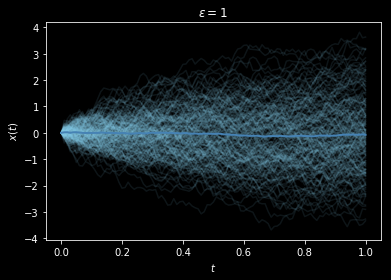

In [4]:
from stochpy.io.plot import trajectory_plot1d
def ensemble_plot1d(*args, **kwargs):
    fig, ax = trajectory_plot1d(*((t, x, {'color': 'skyblue', 'alpha': 0.1}) for t, x in args), **kwargs)
    ax.plot(*np.array(args).mean(axis=0), color='steelblue', lw=2)
    return fig, ax
with plt.style.context(('dark_background')):
    ensemble_plot1d(*[Wiener1D().trajectory(0., 0., T=1, dt=0.01) for n in range(200)], title=r'$\epsilon=1$');

Let us check that the mean square displacement increases linearly with time:

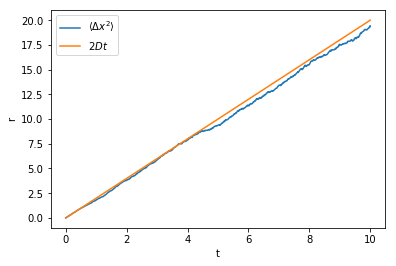

In [5]:
ensemble = np.array([Wiener1D().trajectory(0., 0., T=10, dt=0.01) for n in range(1000)])
time = np.average(ensemble[:, 0, :], axis=0)
ax = plt.axes(xlabel='t', ylabel='r')
ax.plot(time, np.average(ensemble[:, 1, :]**2, axis=0), label=r'$\langle \Delta x^2 \rangle$')
ax.plot(time, 2*time, label=r'$2Dt$')
ax.legend()
plt.show()

## Numerical convergence

Let us now illustrate the numerical convergence of the Euler-Maruyama method. For this, we precompute the Brownian path with respect to which we integrate the SDE, and we vary the time step used for the Euler-Maruyama method.
We compare to the analytical solution.

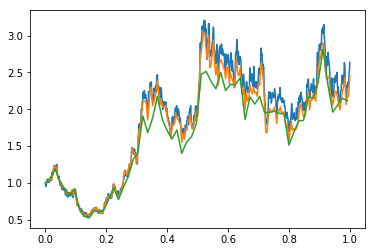

In [6]:
dt_brownian = 0.001
model = DiffusionProcess1D(lambda x, t: 2*x, lambda x, t: x, deterministic=True)
brownian_path = Wiener1D(D=0.5, deterministic=True).trajectory(0., 0., T=1, dt=dt_brownian)
ax = plt.axes()
ax.plot(brownian_path[0], np.exp(1.5*brownian_path[0]+brownian_path[1]))
ax.plot(*model.trajectory(1., 0., T=1, dt=4*dt_brownian, brownian_path=brownian_path));
ax.plot(*model.trajectory(1., 0., T=1, dt=16*dt_brownian, brownian_path=brownian_path));

Slightly more precisely, let us try to illustrate that the Euler-Maruyama has strong order of convergence $1/2$:
$$ \mathbb{E}|X_n-X(t_n)| \leq C \Delta t^{1/2}.$$

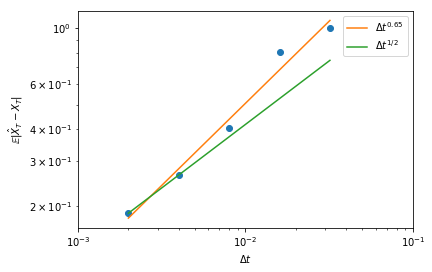

In [7]:
import scipy.stats

ensemble_size = 1000
dt_brownian = 0.002
dtarr = np.array((1, 2, 4, 8, 16))*dt_brownian
model = DiffusionProcess1D(lambda x, t : 2*x, lambda x, t: x)
trajs = np.array([[np.abs(model.trajectory(1., 0., T=1, dt=dt, 
                                           brownian_path=brownian_path)[1][-1]-np.exp(1.5*brownian_path[0][-1]+brownian_path[1][-1])) 
                   for dt in dtarr]
                  for brownian_path in (Wiener1D(D=0.5).trajectory(0., 0., T=1, dt=dt_brownian) for _ in range(ensemble_size))])
error = trajs.mean(axis=0)

ax = plt.axes(xlim=(0.001, 0.1), xlabel=r'$\Delta t$', ylabel=r'$\mathbb{E}|\hat{X}_T-X_T|$', xscale='log', yscale='log')
ax.scatter(dtarr, error)
slope, intercept, _, _, _ = scipy.stats.linregress(np.log10(dtarr), np.log10(error))
ax.plot(dtarr, 10**intercept*dtarr**slope, label=r'$\Delta t^{'+format(slope, '.2f')+'}$', color='C1')
ax.plot(dtarr, error[0]*(dtarr/dtarr[0])**0.5, label=r'$\Delta t^{1/2}$', color='C2')
ax.legend();

# Numerical solution of the Fokker-Planck equation

## Testing timestep

The time step *dt* should be much smaller than *dx^2/D*, with *dx* the spatial resolution and *D* the diffusivity

### Testing *dt* at fixed *dx=0.1* and varying *D*

In [8]:
from stochpy.io.plot import pdf_plot1d
from stochpy.fokkerplanck import FokkerPlanck1D
import numpy as np

/Users/corentin/Library/Python/3.7/lib/python/site-packages/stochpy-0.0.1-py3.7.egg/stochpy/fokkerplanck.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/corentin/Library/Python/3.7/lib/python/site-packages/stochpy-0.0.1-py3.7.egg/stochpy/fokkerplanck.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/corentin/Library/Python/3.7/lib/python/site-packages/stochpy-0.0.1-py3.7.egg/stochpy/fokkerplanck.py:153: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


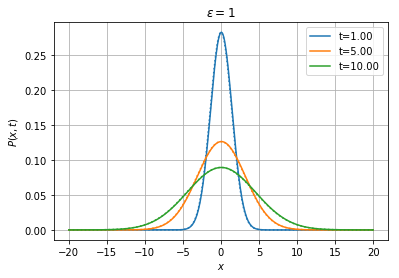

In [9]:
Wiener1D().pdfplot(1, 5, 10, dt=0.001, npts=400, bounds=(-20.0, 20.0), 
                   t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), th=True);

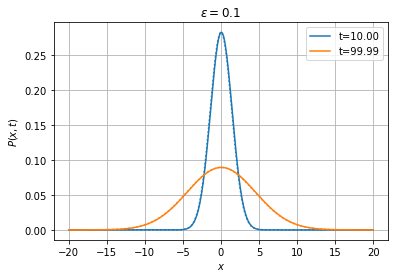

In [10]:
Wiener1D(D=0.1).pdfplot(10, 100, dt=0.01, npts=400, bounds=(-20.0, 20.0), 
                        t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), th=True);

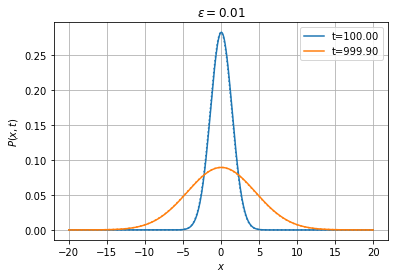

In [11]:
Wiener1D(D=0.01).pdfplot(100, 1000, dt=0.1, npts=400, bounds=(-20.0, 20.0), 
                         t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), th=True);

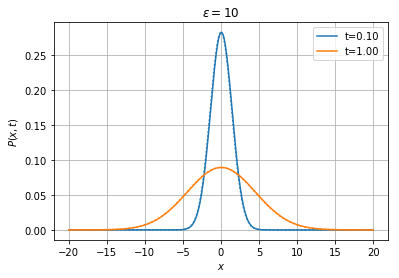

In [12]:
Wiener1D(D=10).pdfplot(0.1, 1, dt=0.0001, npts=400, bounds=(-20.0, 20.0), 
                       t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), th=True);

### Testing *dt* at fixed *D=1* and varying *dx*

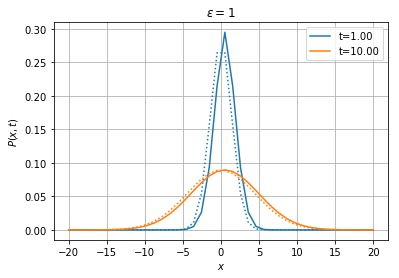

In [13]:
Wiener1D(D=1).pdfplot(1, 10, dt=0.1, npts=40, bounds=(-20.0, 20.0), 
                      t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), th=True);

## Testing Boundary Conditions

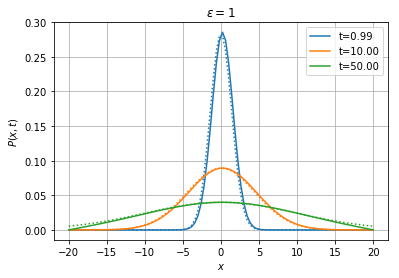

In [14]:
Wiener1D(D=1).pdfplot(1, 10, 50, dt=0.01, npts=100, bounds=(-20.0, 20.0), 
                      t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), th=True);

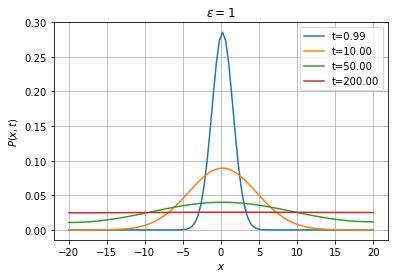

In [15]:
Wiener1D(D=1).pdfplot(1, 10, 50, 200, dt=0.01, npts=100, bounds=(-20.0, 20.0), 
                      t0=0.0, P0='dirac', bc=('reflecting', 'reflecting'));

## Testing the numerical schemes

With the *implicit* and *Crank-Nicolson* schemes, we can afford using much larger timesteps than with the explicit method.

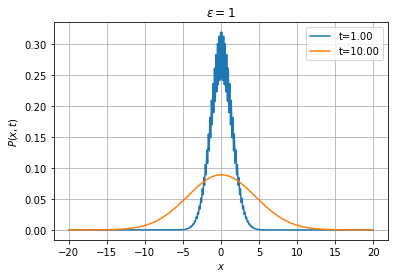

In [16]:
Wiener1D(D=1).pdfplot(1, 10, dt=0.005, npts=400, bounds=(-20.0, 20.0), 
                      t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), method='explicit');

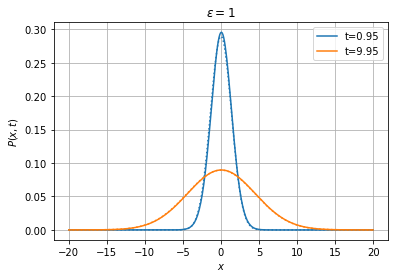

In [17]:
Wiener1D(D=1).pdfplot(1, 10, dt=0.05, npts=400, bounds=(-20.0, 20.0), 
                      t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), method='implicit', th=True);

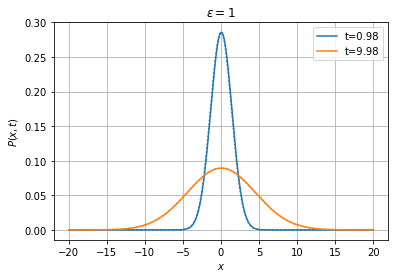

In [18]:
Wiener1D(D=1).pdfplot(1, 10, dt=0.025, npts=400, bounds=(-20.0, 20.0), 
                      t0=0.0, P0='dirac', bc=('absorbing', 'absorbing'), method='cn', th=True);